In [11]:
import onnxruntime as ort
import glob as gb
import pandas as pd
import numpy as np

# Path to trained model
onnx_path = "./../neural_network/saved_models/NN_model_for_uq_analysis.onnx"

# Create session
session = ort.InferenceSession(
    onnx_path,
    providers=["CPUExecutionProvider"]
)

print("Input shape:", session.get_inputs()[0].shape)
print("Output shape:", session.get_outputs()[0].shape)


Input shape: ['N', 2]
Output shape: ['N', 7]


In [2]:
# Read the data from the FlameMaster files
fname = './../neural_network/data/chemtable_FVV_2D_Enthalpy/*.kg'
files = gb.glob(fname)
nfiles = len(files)


# Read column names from the second line of the first file
with open(files[0], 'r') as f:
    lines = f.readlines()
    column_names = lines[1].strip().split('\t')  # Read second line (index 1) and split by whitespace

# Create empty lists to store the data
data_flameMaster = []

# Load and concatenate the data into DataFrames
for f in files:

    df_flameMaster_temp = pd.DataFrame(np.loadtxt(f, skiprows=2, dtype=np.float64),columns=column_names)
    data_flameMaster.append(df_flameMaster_temp)

# Concatenate all data into final DataFrames
df_flameMaster_all = pd.concat(data_flameMaster, ignore_index=True)

#Computing diffusivity 
df_flameMaster_all['Diff [kg/ms]'] = df_flameMaster_all['lambda [W/mK]'] / df_flameMaster_all['cp [J/kgK]']

# Select the relevant columns for input and output
input_data = ['ProgVar', 'TotalEnthalpy [J/kg]']
referenceEnthalpy = 276240

# Shift the enthalpy values to be relative to the reference enthalpy
df_flameMaster_all['TotalEnthalpy [J/kg]'] = df_flameMaster_all['TotalEnthalpy [J/kg]'] - referenceEnthalpy

# Select the relevant columns for input and output
output_data = ['ProdRateProgVar [kg/m^3s]', 'temperature [K]', 'Y-CO', 'density', 'mu [kg/ms]', 'cp [J/kgK]', 'Diff [kg/ms]']

# Create DataFrames for input and output data
X_all = df_flameMaster_all[input_data].to_numpy()
Z_all = df_flameMaster_all[output_data].to_numpy()

# Load mask from trained model
mask = np.load("./../neural_network/train_test_mask.npy")

X_train = X_all[mask].astype(np.float32)
Z_train = Z_all[mask].astype(np.float32)
X_test  = X_all[~mask].astype(np.float32)
Z_test  = Z_all[~mask].astype(np.float32)


In [ ]:
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

y = session.run(
    [output_name],
    {input_name: X_test}
)[0]

print("X_test:", X_test.shape)
print("y_pred:", y.shape)
print("Any NaN?", np.isnan(y).any())

print("Input ranges (X_test):")
for i, name in enumerate(input_data):
    print(
        f"{name:25s} | "
        f"min = {X_test[:, i].min():.5e}, "
        f"max = {X_test[:, i].max():.5e}"
    )

print("\nBaseline output ranges (log-space):")
for j, name in enumerate(output_data):
    print(
        f"{name:30s} | "
        f"min = {y[:, j].min():.5e}, "
        f"max = {y[:, j].max():.5e}"
    )


X_test: (16265, 2)
y_pred: (16265, 7)
Any NaN? False
Input ranges (X_test):
ProgVar                   | min = 8.68707e-11, max = 1.41491e-01
TotalEnthalpy [J/kg]      | min = -5.10846e+05, max = 3.91936e+05

Baseline output ranges (log-space):
ProdRateProgVar [kg/m^3s]      | min = -7.15822e-02, max = 5.84844e+03
temperature [K]                | min = 2.01314e+02, max = 2.05883e+03
Y-CO                           | min = 0.00000e+00, max = 2.19469e-02
density                        | min = 6.66791e-01, max = 6.82126e+00
mu [kg/ms]                     | min = 1.32322e-05, max = 6.83069e-05
cp [J/kgK]                     | min = 1.03931e+03, max = 1.38587e+03
Diff [kg/ms]                   | min = 1.76430e-05, max = 8.71420e-05


### Monte Carlo with Gaussian input noise

In [4]:
import time
import numpy as np
import pandas as pd
from scipy.stats import skew

# Training-domain bounds (interpolation regime)
c_min, c_max = X_train[:, 0].min(), X_train[:, 0].max()
h_min, h_max = X_train[:, 1].min(), X_train[:, 1].max()

# Monte Carlo parameters
N_mc = 300          # fixed, like in the task
sigma_rel = 0.05    # 5% relative uncertainty

# Sample sizes (6 steps)
N_samples_list = np.linspace(100, len(X_test), 6, dtype=int)

rng = np.random.RandomState(0)

# Storage (similar spirit to the course task)
results = {
    "N_samples": [],
    "Mean": [],
    "Std": [],
    "Variance": [],
    "Skewness": [],
    "p05": [],
    "p50": [],
    "p95": [],
    "Computation_time": [],
}

In [5]:
for N_sel in N_samples_list:

    

    # Select N_sel spatial samples
    idx = rng.choice(len(X_test), size=N_sel, replace=False)
    X_sel = X_test[idx]

    outputs_mc = []

    start_time = time.time()

    # --------------------------------------------------
    # Monte Carlo loop (relative noise)
    # --------------------------------------------------
    for k in range(N_mc):

        noise = sigma_rel * X_sel * rng.randn(*X_sel.shape)
        X_noisy = X_sel + noise

        # Clip into interpolation domain
        X_noisy[:, 0] = np.clip(X_noisy[:, 0], c_min, c_max)
        X_noisy[:, 1] = np.clip(X_noisy[:, 1], h_min, h_max)

        y_noisy = session.run(
            [output_name],
            {input_name: X_noisy.astype(np.float32)}
        )[0]

        outputs_mc.append(y_noisy)

    outputs_mc = np.stack(outputs_mc)  # (N_mc, N_sel, 7)

    elapsed = time.time() - start_time

    # --------------------------------------------------
    # Statistics in physical space
    # --------------------------------------------------
    mean_phys = outputs_mc.mean(axis=(0, 1))
    std_phys  = outputs_mc.std(axis=(0, 1))
    var_phys  = std_phys**2
    skew_phys = skew(outputs_mc.reshape(-1, outputs_mc.shape[-1]),axis=0)

    p05 = np.quantile(outputs_mc, 0.05, axis=(0, 1))
    p50 = np.quantile(outputs_mc, 0.50, axis=(0, 1))
    p95 = np.quantile(outputs_mc, 0.95, axis=(0, 1))


    # --------------------------------------------------
    # Store results
    # --------------------------------------------------
    results["N_samples"].append(N_sel)
    results["Mean"].append(mean_phys)
    results["Std"].append(std_phys)
    results["Variance"].append(var_phys)
    results["Skewness"].append(skew_phys)
    results["p05"].append(p05)
    results["p50"].append(p50)
    results["p95"].append(p95)
    results["Computation_time"].append(elapsed)

    print(f"N_samples = {N_sel:6d} | time = {elapsed:6.2f} s")



N_samples =    100 | time =   0.03 s
N_samples =   3333 | time =   5.76 s
N_samples =   6566 | time =  42.27 s
N_samples =   9799 | time =  58.65 s
N_samples =  13032 | time =  64.53 s
N_samples =  16265 | time =  39.96 s


In [6]:
import numpy as np
from scipy.stats import skew
import pandas as pd

# ==============================================================
# Global statistics in physical space
# (aggregate over MC samples AND selected test points)
# ==============================================================

N_target = 16265 

i = results["N_samples"].index(N_target)

mean = results["Mean"][i]
std  = results["Std"][i]
var  = results["Variance"][i]
skew = results["Skewness"][i]

p05  = results["p05"][i]
p50  = results["p50"][i]
p95  = results["p95"][i]

df_uq = pd.DataFrame({
    "Output": output_data,
    "Mean": mean,
    "Variance": var,
    "Skewness": skew,
    "p05": p05,
    "p50 (median)": p50,
    "p95": p95,
})

df_uq

,Output,Mean,Variance,Skewness,p05,p50 (median),p95
0,ProdRateProgVar [kg/m^3s],218.478195,3.980236e+05,4.723743,-1.108186,0.640357,1401.700806
1,temperature [K],1471.472168,1.592805e+05,-1.202103,587.073547,1544.590210,1961.255005
2,Y-CO,0.003725,2.495975e-05,1.457195,0.000000,0.001490,0.014963
3,density,1.106855,4.824635e-01,4.163445,0.697933,0.886115,2.339670
4,mu [kg/ms],0.000054,1.184815e-10,-1.542499,0.000030,0.000057,0.000066
5,cp [J/kgK],1332.838257,6.295209e+03,-2.552241,1116.802734,1331.568237,1377.162109
6,Diff [kg/ms],0.000069,1.891238e-10,-1.433923,0.000039,0.000073,0.000085


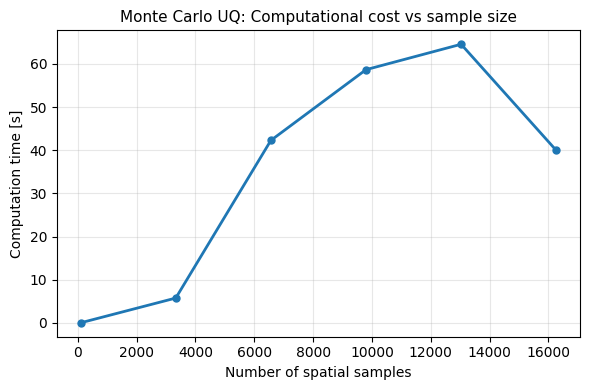

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_results = pd.DataFrame({
    "N_samples": results["N_samples"],
    "Computation_time [s]": results["Computation_time"],
})


N_samples = df_results["N_samples"].values
times = df_results["Computation_time [s]"].values

plt.figure(figsize=(6, 4))
plt.plot(N_samples, times, "-o", linewidth=2, markersize=5)

plt.xlabel("Number of spatial samples", fontsize=10)
plt.ylabel("Computation time [s]", fontsize=10)
plt.title("Monte Carlo UQ: Computational cost vs sample size", fontsize=11)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


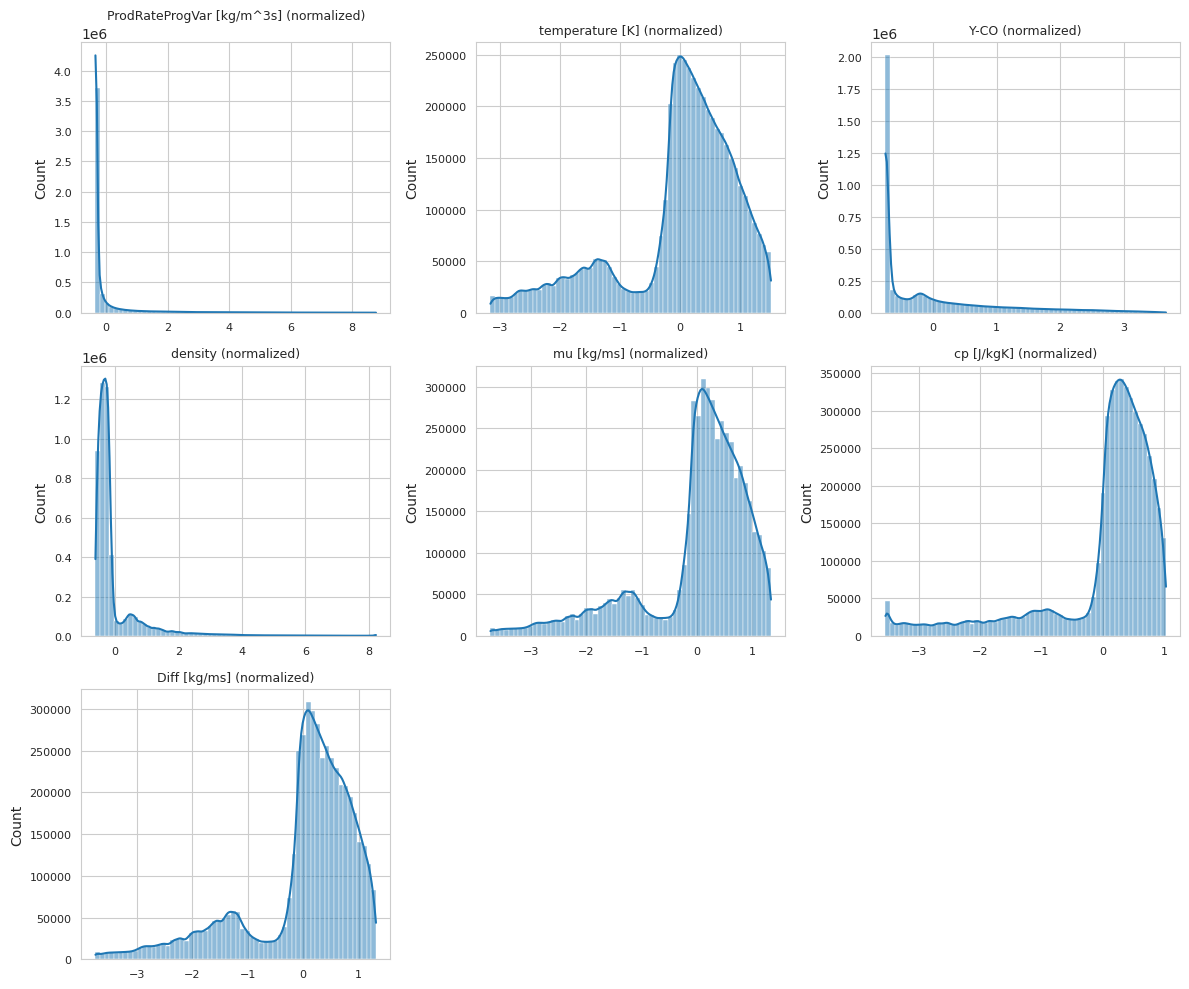

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

# Flatten MC and spatial dimensions
Y_flat = outputs_mc.reshape(-1, outputs_mc.shape[-1])

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

for j, name in enumerate(output_data):
    ax = axes[j]

    vals = Y_flat[:, j]
    vals_norm = (vals - vals.mean()) / vals.std()

    sns.histplot(
        vals_norm,
        bins=60,
        kde=True,
        ax=ax
    )

    ax.set_title(name + " (normalized)", fontsize=9)
    ax.tick_params(labelsize=8)

for k in range(len(output_data), len(axes)):
    axes[k].set_visible(False)

plt.tight_layout()
plt.show()


/tmp/zp252136/login23-1_40134/ipykernel_313067/3645430908.py:11: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df_norm, inner="quartile", scale="width")


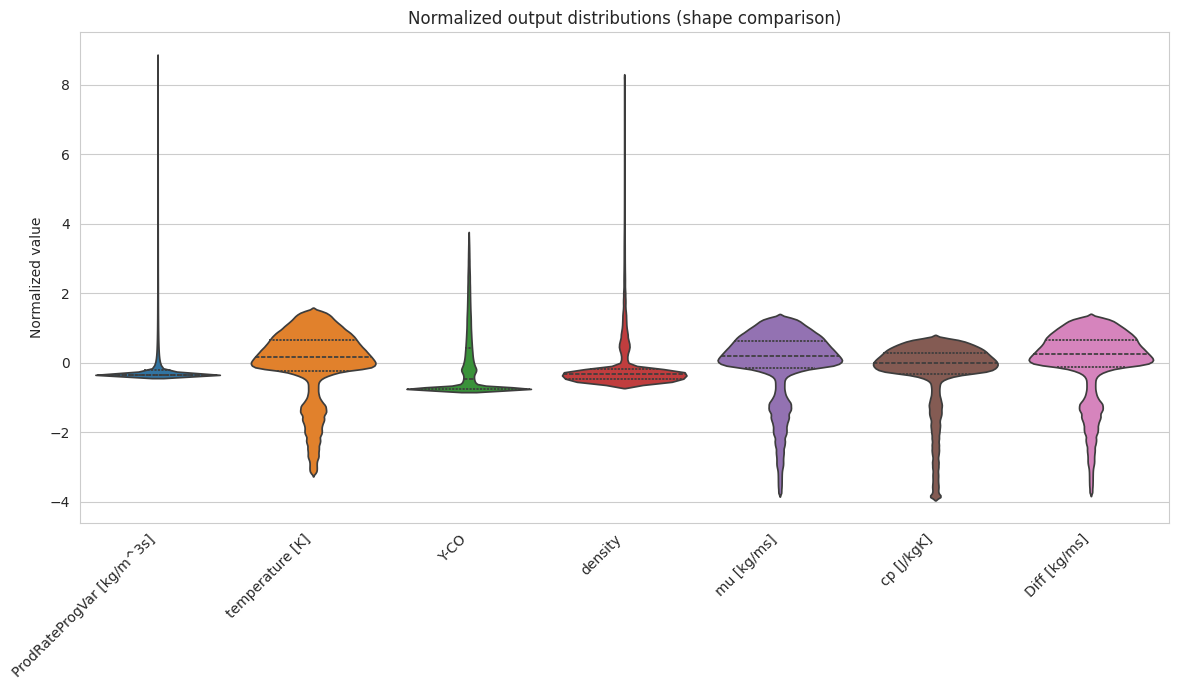

In [9]:
import pandas as pd

df_long = pd.DataFrame(
    Y_flat,
    columns=output_data
)

df_norm = (df_long - df_long.mean()) / df_long.std()

plt.figure(figsize=(12, 7))
sns.violinplot(data=df_norm, inner="quartile", scale="width")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Normalized value")
plt.title("Normalized output distributions (shape comparison)")
plt.tight_layout()
plt.show()


### Saving results

In [10]:
import numpy as np

np.save("outputs_mc.npy", outputs_mc)
